# Alpamayo-R1 Testing

This notebook will load some example data from the NVIDIA [PhysicalAI-AV Dataset](https://huggingface.co/datasets/nvidia/PhysicalAI-Autonomous-Vehicles) and run the Alpamayo-R1 model on it, producing and visualizing output trajectories and associated reasoning traces.

In [ ]:
!git clone https://github.com/NVlabs/alpamayo.git
!pip install mediapy transformers accelerate bitsandbytes protobuf sentencepiece

In [ ]:
# before this step remove flash-attn in the project.toml file
!sed -i '/flash-attn>=2.8.3/d' /content/alpamayo/pyproject.toml
%cd alpamayo
!pip install -e .
%cd notebooks

In [2]:
from huggingface_hub import login
login()

In [3]:
import copy
import numpy as np
import mediapy as mp
import pandas as pd

import torch
from transformers import BitsAndBytesConfig
from alpamayo_r1.models.alpamayo_r1 import AlpamayoR1
from alpamayo_r1.load_physical_aiavdataset import load_physical_aiavdataset
from alpamayo_r1 import helper

### Load model and construct data preprocessor

In [ ]:
# using 8-bit quantization
# quant_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     llm_int8_threshold=6.0
# )

# model = AlpamayoR1.from_pretrained(
#     "nvidia/Alpamayo-R1-10B",
#     quantization_config=quant_config,
#     device_map="auto"
# )

# when using A100
model = AlpamayoR1.from_pretrained(
    "nvidia/Alpamayo-R1-10B",
    dtype=torch.bfloat16,
    attn_implementation="sdpa").to("cuda")

processor = helper.get_processor(model.tokenizer)

### Load and prepare data

In [5]:
clip_ids = pd.read_parquet("clip_ids.parquet")["clip_id"].tolist()
clip_id = clip_ids[500]
# clip_id = '030c760c-ae38-49aa-9ad8-f5650a545d26' for 774

In [6]:
'''
returns A dictionary with the following keys:
    - image_frames: torch.Tensor of shape (N_cameras, num_frames, 3, H, W)
    - camera_indices: torch.Tensor of shape (N_cameras,)
    - ego_history_xyz: torch.Tensor of shape (1, 1, num_history_steps, 3)
    - ego_history_rot: torch.Tensor of shape (1, 1, num_history_steps, 3, 3)
    - ego_future_xyz: torch.Tensor of shape (1, 1, num_future_steps, 3)
    - ego_future_rot: torch.Tensor of shape (1, 1, num_future_steps, 3, 3)
    - relative_timestamps: torch.Tensor of shape (N_cameras, num_frames)
    - absolute_timestamps: torch.Tensor of shape (N_cameras, num_frames)
    - t0_us: The t0 timestamp used
    - clip_id: The clip ID
'''
data = load_physical_aiavdataset(clip_id)

## Visualizing data

,,,
,,,
,,,
,,,

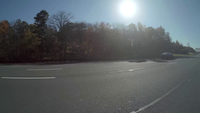
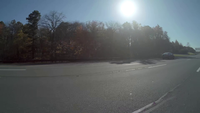
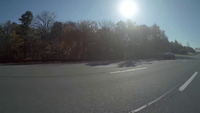
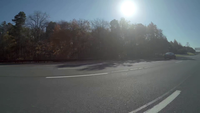
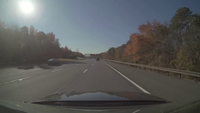
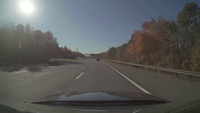
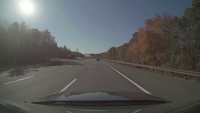
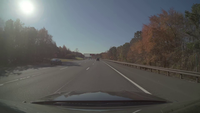
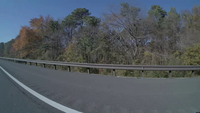
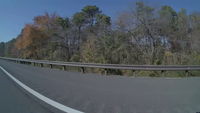
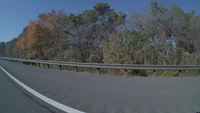
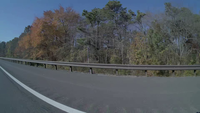
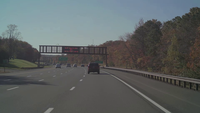
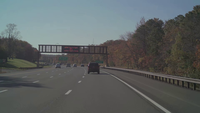
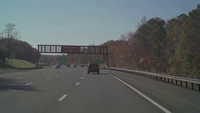
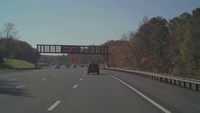

In [9]:
mp.show_images(data["image_frames"].flatten(0, 1).permute(0, 2, 3, 1), columns=4, width=200)

In [10]:
video_tensor = data["image_frames"]
if video_tensor.device.type != 'cpu':
    video_tensor = video_tensor.cpu()

video_permuted = video_tensor.permute(1, 3, 0, 4, 2)
T, H, N_cams, W, C = video_permuted.shape
video_stitched = video_permuted.reshape(T, H, N_cams * W, C)

video_np = video_stitched.numpy()
if video_np.max() <= 1.0:
    video_np = (video_np * 255).astype('uint8')
else:
    video_np = video_np.astype('uint8')

print("Showing panoramic video of all angles:")
mp.show_video(video_np, fps=4, width=800)

Showing panoramic video of all angles:


### Creating Input:

In [7]:
# prompt for testing
prompt_2 = 'Could you provide the exact speed I should maintain for every subsequent second? provide precise mathematical \
and physical formulations that you will use to calculate this, step by step. Additionally, based on these \
calculations, specify precisely how much I should decrease or increase the speed of the car.'

prompt_3 = '''What actions should I take? Could you provide the exact speed I should maintain for every subsequent
second? provide precise mathematical and physical formulations that you will use to calculate this, step by step.
Additionally, based on these calculations, specify precisely how much I should decrease or increase the speed
of the car. I have control over both the throttle and the brake for speed control, each ranging from 0 to 1. To
facilitate this, I request two lists:
1. SPEED_LIST: Specify the exact amount of throttle that should be applied at each step. 2. BRAKE_LIST:
Specify the exact amount of brake that should be applied at each step. Provide the speed and brake information
in the form of lists, named SPEED_CONTROL and BRAKE_CONTROL, respectively.'''

# focus on instruction prompts: "stop over there", "in 400ft turn right"
prompt_4 = "I am in a rush, i need to get to the hospital fast, what actions should I take?"


In [ ]:
messages = helper.create_message(data["image_frames"].flatten(0, 1))

# custom instruct
messages[0]["content"][0]['text'] = prompt_4

print(messages[0]["content"])

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=False,
    continue_final_message=True,
    return_dict=True,
    return_tensors="pt",
)
print("seq length:", inputs.input_ids.shape)
model_inputs = {
    "tokenized_data": inputs,
    "ego_history_xyz": data["ego_history_xyz"],
    "ego_history_rot": data["ego_history_rot"],
}
model_inputs = helper.to_device(model_inputs, "cuda")

### Model inference

In [ ]:
torch.cuda.empty_cache()
torch.cuda.manual_seed_all(42)
with torch.autocast("cuda", dtype=torch.bfloat16):
    pred_xyz, pred_rot, extra = model.sample_trajectories_from_data_with_vlm_rollout(
        data=copy.deepcopy(model_inputs),
        top_p=0.98,
        temperature=0.6,
        num_traj_samples=1,  # Feel free to raise this for more output trajectories and CoC traces.
        max_generation_length=256,
        return_extra=True,
    )

# the size is [batch_size, num_traj_sets, num_traj_samples]
print("Chain-of-Causation (per trajectory):\n", extra["cot"][0])

'''Chain-of-Causation (per trajectory):
 [['Slow down to keep distance to the lead vehicle.']]'''

### Speed and brake list

In [ ]:
import matplotlib.pyplot as plt


def rotate_90cc(xy):
    # Rotate (x, y) by 90 deg CCW -> (y, -x)
    return np.stack([-xy[1], xy[0]], axis=0)


for i in range(pred_xyz.shape[2]):
    pred_xy = pred_xyz.cpu()[0, 0, i, :, :2].T.numpy()
    pred_xy_rot = rotate_90cc(pred_xy)
    gt_xy = data["ego_future_xyz"].cpu()[0, 0, :, :2].T.numpy()
    gt_xy_rot = rotate_90cc(gt_xy)
    plt.plot(*pred_xy_rot, "o-", label=f"Predicted Trajectory #{i + 1}")
plt.ylabel("y coordinate (meters)")
plt.xlabel("x coordinate (meters)")
plt.plot(*gt_xy_rot, "r-", label="Ground Truth Trajectory")
plt.legend(loc="best")
plt.axis("equal")

In [ ]:
pred_xy = pred_xyz.cpu().numpy()[0, 0, :, :, :2].transpose(0, 2, 1)
diff = np.linalg.norm(pred_xy - gt_xy[None, ...], axis=1).mean(-1)
print("minADE:", diff.min(), "meters")

In [ ]:
import torch
import numpy as np

# 1. Get the trajectory for the first sample
# pred_xyz shape: [1, 1, 64, 3] -> We want [64, 3]
traj = pred_xyz[0, 0].cpu().numpy()

# 2. Calculate Velocity (Distance / Time)
dt = 0.1  # Alpamayo outputs at 10Hz
# Calculate distance between each step
deltas = np.diff(traj, axis=0) # Shape: [63, 3]
distances = np.linalg.norm(deltas[:, :2], axis=1) # Ignore Z for speed, just use X/Y
velocities = distances / dt  # Speed in m/s

# 3. Calculate Acceleration (Change in Velocity / Time)
accelerations = np.diff(velocities) / dt # Shape: [62]

# 4. Convert to "Throttle" and "Brake" (Heuristic)
SPEED_CONTROL = []
BRAKE_CONTROL = []

for acc in accelerations:
    if acc > 0:
        # Accelerating: Map 0.0 to 3.0 m/s^2 -> 0.0 to 1.0 Throttle
        throttle = min(acc / 3.0, 1.0)
        brake = 0.0
    else:
        # Decelerating: Map 0.0 to -5.0 m/s^2 -> 0.0 to 1.0 Brake
        throttle = 0.0
        brake = min(abs(acc) / 5.0, 1.0)

    SPEED_CONTROL.append(round(float(throttle), 2))
    BRAKE_CONTROL.append(round(float(brake), 2))

# 5. Print the lists you wanted
print("SPEED_LIST (approx):", SPEED_CONTROL)
print("BRAKE_LIST (approx):", BRAKE_CONTROL)